# ¿Existe relación entre el Máximo Nivel Educativo Alcanzado por una mujer y el número de hijos que tiene?

El siguiente Excel puede ser descargado de la página del INDEC comentada a continuación.
https://www.indec.gob.ar/ftp/cuadros/poblacion/c2022_corrientes_fecundidad_c6_7.xlsx 

## Preprocesamiento de Datos

### Librerías y funciones auxiliares.

Antes de empezar con el análisis, vamos a empezar importando las librerias necesarias y definiendo funciones de procesamiento de datos.

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [166]:
def pandas_friendly(X):
    df = X.copy()
    df = df.iloc[1:].reset_index(drop=True)

    # Merge the second and third rows, filling NaNs
    merged_header = df.iloc[0].combine_first(df.iloc[1])

    # Set the merged row as column names
    df.columns = merged_header

    # Drop the now redundant rows
    df = df.iloc[2:].reset_index(drop=True)

    df = df.iloc[:-3].reset_index(drop=True)
    
    df.columns = df.columns.to_list()  # Ensure columns are a list
    
    df.columns.values[2] = 0

    df = df.reset_index()
    
    df = df.drop(columns='index')
    
    return df

In [167]:
def egb_poli_drop(X):
    df = X.copy()
    ind_to_drop = [4,5,8,9]

    df = df.drop(ind_to_drop)

    return df

In [168]:
def merge_rows_by_index(X, idx1, idx2):
    df = X.copy()
    df.iloc[idx1, 1:] = df.iloc[idx2, 1:] + df.iloc[idx1, 1:]
    return df.drop(idx2).reset_index(drop=True)

In [169]:
def incomplete_tf(X):
    df = X.copy()
    df = merge_rows_by_index(df, 1,2)
    df = merge_rows_by_index(df, 2,3)
    df = merge_rows_by_index(df, 3,4)
    df = merge_rows_by_index(df, 3,5)
    df = merge_rows_by_index(df, 5,6)
    return df

In [170]:
def name_changer_for_simplicity(X):
    df = X.copy()
    df.iloc[-1,0] = 'Posgrado completo'
    df.columns.values[0] = 'Maximo Nivel Ed Alcanzado'
    df.columns.values[1] = 'Mujeres'
    return df 

In [171]:
def total_drop(X):
    df = X.copy()
    df_no_tot = df.copy()
    df_no_tot = df.drop(index=0)
    return df_no_tot

In [172]:
def children_group(X):
    df = X.copy()
    df_chil_group = df.copy()
    df_chil_group['1+'] = df_chil_group[[1.0, 2.0, 3.0, 4.0, '5 y más']].sum(axis=1)
    df_chil_group = df_chil_group.drop(columns=[1.0, 2.0, 3.0, 4.0, '5 y más'])
    return df_chil_group

In [173]:
def ungroup_map(X):
    """
    Convierte un dataset en formato estándar, donde cada fila representa
    una mujer con una combinación de nivel educativo y categoría.
    """

    df = X.copy()
    # Forzar las columnas numéricas a ser valores numéricos
    for col in df.columns[2:]:  # Ignora las dos primeras columnas
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    rows = []
    for _, row in df.iterrows():
        nivel = row.iloc[0]  # Primera columna con el nivel educativo
        for col in df.columns[2:]:  # Omitimos la columna de mujeres
            count = row[col]
            if pd.notna(count) and isinstance(count, (int, float)):  # Asegura que sea número
                rows.extend([[nivel, col]] * int(count))
    
    st_df =pd.DataFrame(rows, columns=["Maximo Nivel Ed Alcanzado", "Num Hijos"])

    st_df['Maximo Nivel Ed Alcanzado'] = st_df['Maximo Nivel Ed Alcanzado'].map({'Sin instrucción':0, 'Primario completo':1,'Secundario completo':2,'Terciario no universitario completo':3,'Universitario de grado completo':4,'Posgrado completo' : 5})
    st_df['Num Hijos'] = st_df['Num Hijos'].map({0:0, 1:1,2:2,3:3,4:4,'5 y más' : 5})

    # Crear DataFrame final
    return st_df

### Lectura y preprocesamiento del dataset.

Comenzamos leyendo el archivo Excel, en particular, la hoja que nos interesa es la que contiene al Cuadro 6.7.

In [174]:
df = pd.read_excel('c2022_corrientes_fecundidad_c6_7.xlsx', sheet_name='Cuadro\xa06.7')

Como vemos, el formato no es el más amigable para Pandas, por lo tanto, debemos realizar ciertos ajustes de formato.

In [175]:
df

,"Censo Nacional de Población, Hogares y Viviendas 2022",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,Cuadro 6.7. Provincia de Corrientes. Mujeres d...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Màximo nivel educativo alcanzado y completitud...,Mujeres de 14 a 49 años que asistieron a un es...,Cantidad de hijas e hijos nacidos vivos,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,Ninguno,1.0,2.0,3.0,4.0,5 y más
3,Total,213409,47210,49653.0,50916.0,30156.0,15608.0,19866
4,Sin instrucción,1267,478,257.0,205.0,115.0,77.0,135
5,Primario incompleto,15094,1629,1998.0,2640.0,2541.0,1916.0,4370
6,Primario completo,33516,3951,5505.0,7395.0,6042.0,4115.0,6508
7,EGB incompleto,623,69,112.0,160.0,133.0,63.0,86
8,EGB completo,722,96,151.0,160.0,135.0,78.0,102
9,Secundario incompleto,35934,5930,8331.0,8896.0,5989.0,3271.0,3517


In [176]:
df = pandas_friendly(df)

Ahora si tenemos un formato más ameno...

In [177]:
df

,Màximo nivel educativo alcanzado y completitud del nivel,Mujeres de 14 a 49 años que asistieron a un establecimiento educativo(¹),0,1.0,2.0,3.0,4.0,5 y más
0,Total,213409,47210,49653.0,50916.0,30156.0,15608.0,19866
1,Sin instrucción,1267,478,257.0,205.0,115.0,77.0,135
2,Primario incompleto,15094,1629,1998.0,2640.0,2541.0,1916.0,4370
3,Primario completo,33516,3951,5505.0,7395.0,6042.0,4115.0,6508
4,EGB incompleto,623,69,112.0,160.0,133.0,63.0,86
5,EGB completo,722,96,151.0,160.0,135.0,78.0,102
6,Secundario incompleto,35934,5930,8331.0,8896.0,5989.0,3271.0,3517
7,Secundario completo,62490,15387,16469.0,15310.0,8219.0,3725.0,3380
8,Polimodal incompleto,728,116,175.0,197.0,115.0,55.0,70
9,Polimodal completo,3180,734,878.0,885.0,439.0,135.0,109


Por simplicidad, y dado que, relativamente son números bajos comparados con las categorías de Primaria y Secundaria, no vamos a considerar EGB ni Polimodal en el análisis...

In [178]:
df = egb_poli_drop(df)

In [179]:
df

,Màximo nivel educativo alcanzado y completitud del nivel,Mujeres de 14 a 49 años que asistieron a un establecimiento educativo(¹),0,1.0,2.0,3.0,4.0,5 y más
0,Total,213409,47210,49653.0,50916.0,30156.0,15608.0,19866
1,Sin instrucción,1267,478,257.0,205.0,115.0,77.0,135
2,Primario incompleto,15094,1629,1998.0,2640.0,2541.0,1916.0,4370
3,Primario completo,33516,3951,5505.0,7395.0,6042.0,4115.0,6508
6,Secundario incompleto,35934,5930,8331.0,8896.0,5989.0,3271.0,3517
7,Secundario completo,62490,15387,16469.0,15310.0,8219.0,3725.0,3380
10,Terciario no universitario incompleto,8884,2272,2500.0,2332.0,1043.0,427.0,310
11,Terciario no universitario completo,27488,8047,7581.0,7094.0,3054.0,1034.0,678
12,Universitario de grado incompleto,5136,1726,1247.0,1236.0,608.0,184.0,135
13,Universitario de grado completo,12852,5179,3096.0,2995.0,1094.0,298.0,190


Nuevamente, para simplificar el análisis, vamos a considerar un nivel incompleto como el nivel anterior completo. Es decir, "Primario incompleto" == "Sin instrucción", "Secundario incompleto" == "Primario Completo" y así. Notar que en "Secundario Completo" incluiremos tanto Universitario como Terciario no universitario incompleto.

In [180]:
df = incomplete_tf(df)

In [181]:
df

,Màximo nivel educativo alcanzado y completitud del nivel,Mujeres de 14 a 49 años que asistieron a un establecimiento educativo(¹),0,1.0,2.0,3.0,4.0,5 y más
0,Total,213409,47210,49653.0,50916.0,30156.0,15608.0,19866
1,Sin instrucción,16361,2107,2255.0,2845.0,2656.0,1993.0,4505
2,Primario completo,69450,9881,13836.0,16291.0,12031.0,7386.0,10025
3,Secundario completo,76510,19385,20216.0,18878.0,9870.0,4336.0,3825
4,Terciario no universitario completo,27488,8047,7581.0,7094.0,3054.0,1034.0,678
5,Universitario de grado completo,13307,5336,3217.0,3088.0,1142.0,312.0,212
6,"Posgrado (especialización, maestría o doctorad...",3356,1094,845.0,906.0,335.0,85.0,91


Vamos además a abreviar los nombres de ciertas categorias.

In [182]:
df =name_changer_for_simplicity(df)

In [183]:
df

,Maximo Nivel Ed Alcanzado,Mujeres,0,1.0,2.0,3.0,4.0,5 y más
0,Total,213409,47210,49653.0,50916.0,30156.0,15608.0,19866
1,Sin instrucción,16361,2107,2255.0,2845.0,2656.0,1993.0,4505
2,Primario completo,69450,9881,13836.0,16291.0,12031.0,7386.0,10025
3,Secundario completo,76510,19385,20216.0,18878.0,9870.0,4336.0,3825
4,Terciario no universitario completo,27488,8047,7581.0,7094.0,3054.0,1034.0,678
5,Universitario de grado completo,13307,5336,3217.0,3088.0,1142.0,312.0,212
6,Posgrado completo,3356,1094,845.0,906.0,335.0,85.0,91


Para la mayor parte de nuestro análisis, no necesitamos la primera fila, donde se encuentra el total por categoría.

In [184]:
df_no_tot = total_drop(df)

In [185]:
df_no_tot

,Maximo Nivel Ed Alcanzado,Mujeres,0,1.0,2.0,3.0,4.0,5 y más
1,Sin instrucción,16361,2107,2255.0,2845.0,2656.0,1993.0,4505
2,Primario completo,69450,9881,13836.0,16291.0,12031.0,7386.0,10025
3,Secundario completo,76510,19385,20216.0,18878.0,9870.0,4336.0,3825
4,Terciario no universitario completo,27488,8047,7581.0,7094.0,3054.0,1034.0,678
5,Universitario de grado completo,13307,5336,3217.0,3088.0,1142.0,312.0,212
6,Posgrado completo,3356,1094,845.0,906.0,335.0,85.0,91


Para poder realizar ciertos gráficos, nos será de utilidad "desagrupar" el dataset, donde cada fila representa una mujer junto a su Nivel Ed y Num de Hijos.

In [186]:
standard_df = ungroup_map(df_no_tot)

In [187]:
standard_df

,Maximo Nivel Ed Alcanzado,Num Hijos
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
206467,5,5
206468,5,5
206469,5,5
206470,5,5


Para el primer análisis, vamos a considerar si una mujer tiene o no hijos, y luego añadiremos la cantidad de hijos, en caso de que los tenga.

In [188]:
df_no_tot_child_grouped = children_group(df_no_tot)

In [189]:
df_no_tot_child_grouped

,Maximo Nivel Ed Alcanzado,Mujeres,0,1+
1,Sin instrucción,16361,2107,14254.0
2,Primario completo,69450,9881,59569.0
3,Secundario completo,76510,19385,57125.0
4,Terciario no universitario completo,27488,8047,19441.0
5,Universitario de grado completo,13307,5336,7971.0
6,Posgrado completo,3356,1094,2262.0


## Análisis del Conjunto de Datos

Empecemos visualizando el número de mujeres que tenemos por grupos.

In [190]:
df_no_tot

,Maximo Nivel Ed Alcanzado,Mujeres,0,1.0,2.0,3.0,4.0,5 y más
1,Sin instrucción,16361,2107,2255.0,2845.0,2656.0,1993.0,4505
2,Primario completo,69450,9881,13836.0,16291.0,12031.0,7386.0,10025
3,Secundario completo,76510,19385,20216.0,18878.0,9870.0,4336.0,3825
4,Terciario no universitario completo,27488,8047,7581.0,7094.0,3054.0,1034.0,678
5,Universitario de grado completo,13307,5336,3217.0,3088.0,1142.0,312.0,212
6,Posgrado completo,3356,1094,845.0,906.0,335.0,85.0,91


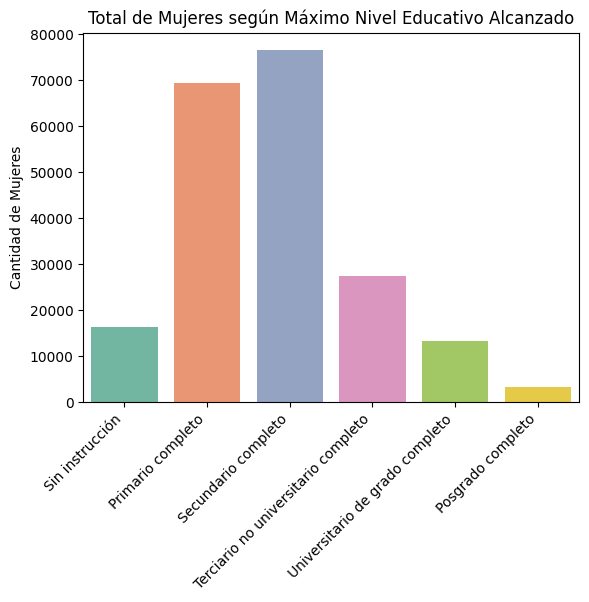

In [191]:
aux_c1 = df_no_tot.columns.values[0]
aux_c2 = df_no_tot.columns.values[1]
try:
    sns.barplot(data=df_no_tot, x=aux_c1, y=aux_c2, palette='Set2')
    plt.title('Total de Mujeres según Máximo Nivel Educativo Alcanzado')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('')
    plt.ylabel('Cantidad de Mujeres')
    plt.show()
except:
    sns.barplot(data=df_no_tot, x='Màximo nivel educativo alcanzado y completitud del nivel', y='Mujeres de 14 a 49 años que asistieron a un establecimiento educativo(¹)', palette='Set2')
    plt.title('Total de Mujeres según Máximo Nivel Educativo Alcanzado')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('')
    plt.ylabel('Cantidad de Mujeres')
    plt.show()

Text(0.5, 1.0, 'Densidad de Mujeres según Máximo Nivel Ed Alcanzado')

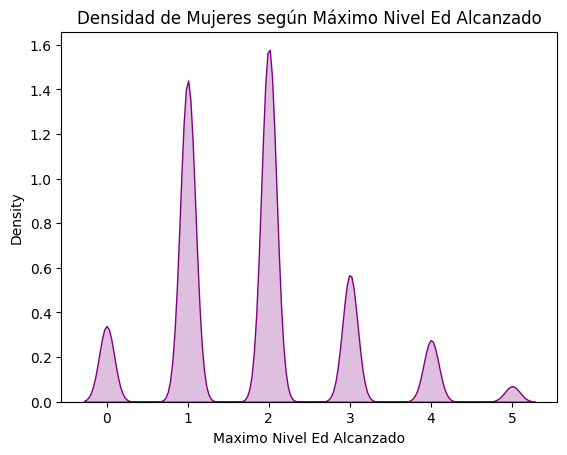

In [192]:
sns.kdeplot(data=standard_df, x='Maximo Nivel Ed Alcanzado', shade=True, color='Purple')
plt.title('Densidad de Mujeres según Máximo Nivel Ed Alcanzado')

Vemos que la mayoría de las mujeres presentes en el conjunto de datos tiene hasta el Secundario Completo. Además, podemos ver que la mayoría de las mujeres tiene dos hijos.

Text(0.5, 1.0, 'Densidad de Mujeres según Número de Hijos')

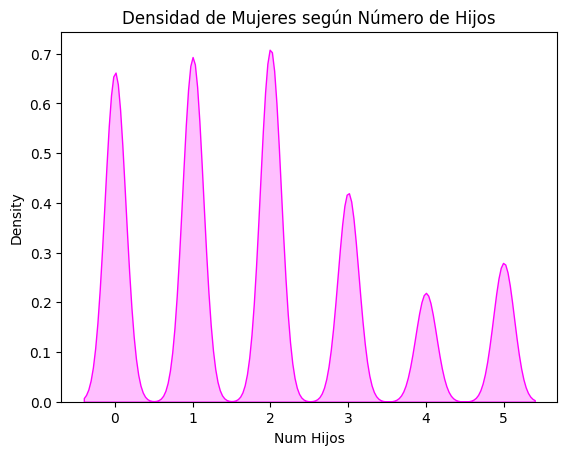

In [193]:
sns.kdeplot(data=standard_df, x='Num Hijos', shade=True, color='Magenta')
plt.title('Densidad de Mujeres según Número de Hijos')

### Análisis por presencia o no de hijos.

Ahora, analicemos cuántas mujeres tienen o no hijos, según el grupo al que pertenecen.

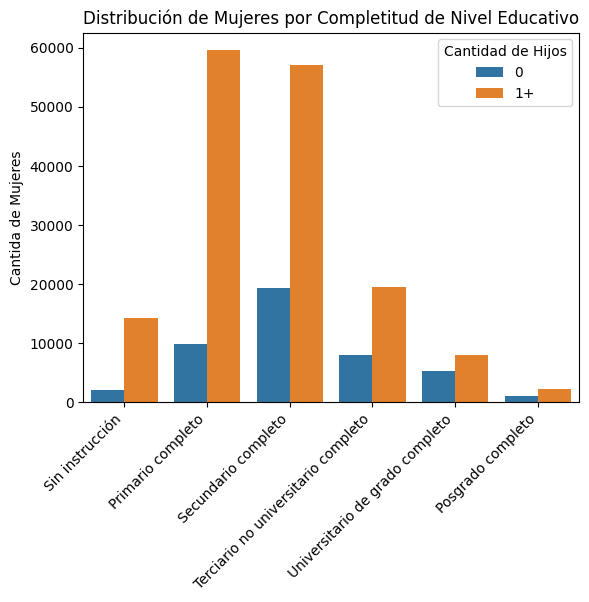

In [194]:
# Melt the DataFrame to long format
df_melted = pd.melt(df_no_tot_child_grouped, id_vars=[aux_c1, 
                                                              aux_c2], 
                    value_vars=[0, '1+'], 
                    var_name='Component', value_name='Value')

# Create the barplot
sns.barplot(data=df_melted, 
            x=aux_c1, 
            y='Value', 
            hue='Component')
plt.legend(title='Cantidad de Hijos')
plt.title('Distribución de Mujeres por Completitud de Nivel Educativo')
plt.xlabel('')
plt.ylabel('Cantida de Mujeres')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

A partir del gráfico anterior, podemos observar como la brecha entre tener o no hijos, se va reduciendo a medida que aumenta el nivel educativo. Sin embargo, sería interesante analizar más de cerca en cada categoría, lo cual haremos a continuación.

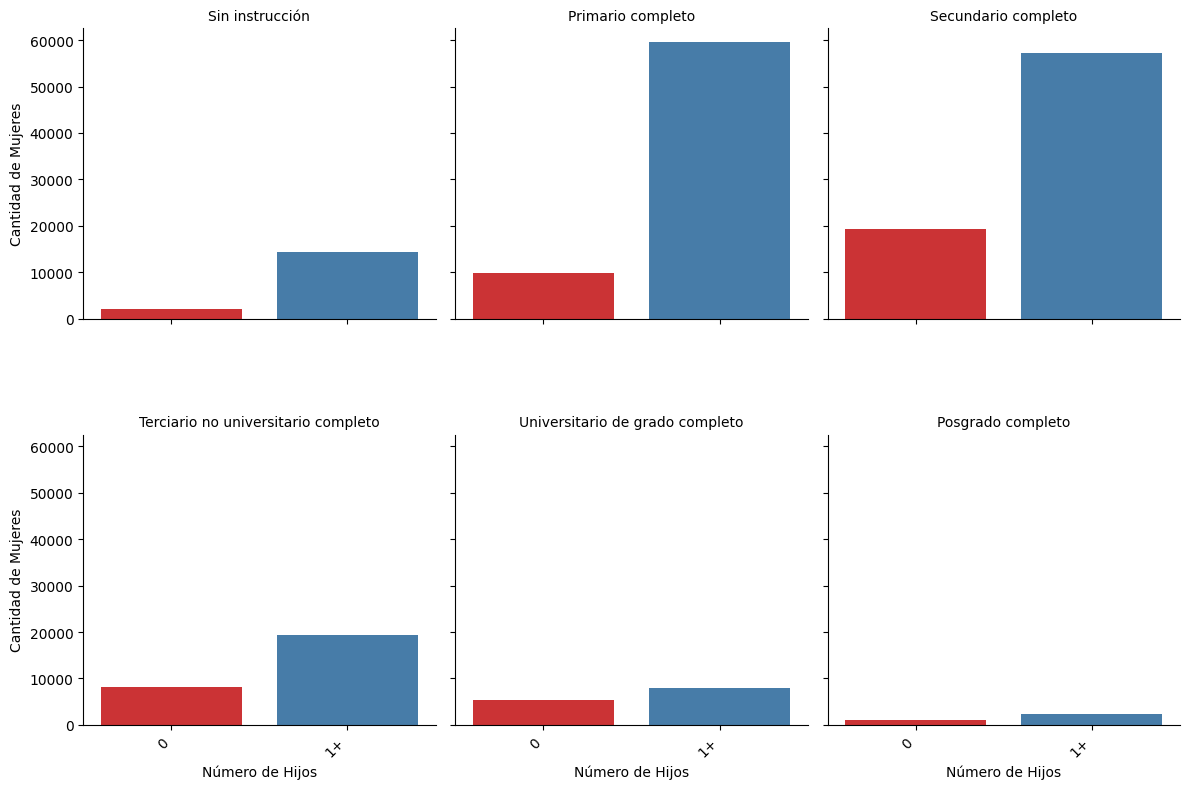

In [195]:
# Create the FacetGrid
g = sns.FacetGrid(df_melted, col=aux_c1, 
                  col_wrap=3,  # Number of plots per row, adjust as needed
                  height=4)    # Height of each plot

# Map the barplot to each category
g.map(sns.barplot, 'Component', 'Value', order=[0, '1+'], palette='Set1')

# Add axis labels and titles
g.set_axis_labels('Número de Hijos', 'Cantidad de Mujeres')
g.set_titles("{col_name}")  # This will set the category names as titles for each plot

# Rotate the x-axis labels for better visibility
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Adjust the layout to avoid overlap
g.figure.tight_layout()
g.figure.subplots_adjust(hspace=0.4)  # Increase vertical spacing between rows

# Show the plot
plt.show()

En efecto, podemos ver como la brecha entre ambas categorías parece ir reduciéndose. Debemos tener cuidado con Posgrado Completo pues la muestra que tenemos es pequeña comparada a las otras categorías, especialmente Secundaria y Primaria. Veamos ahora las proporciones en cada nivel educativo.

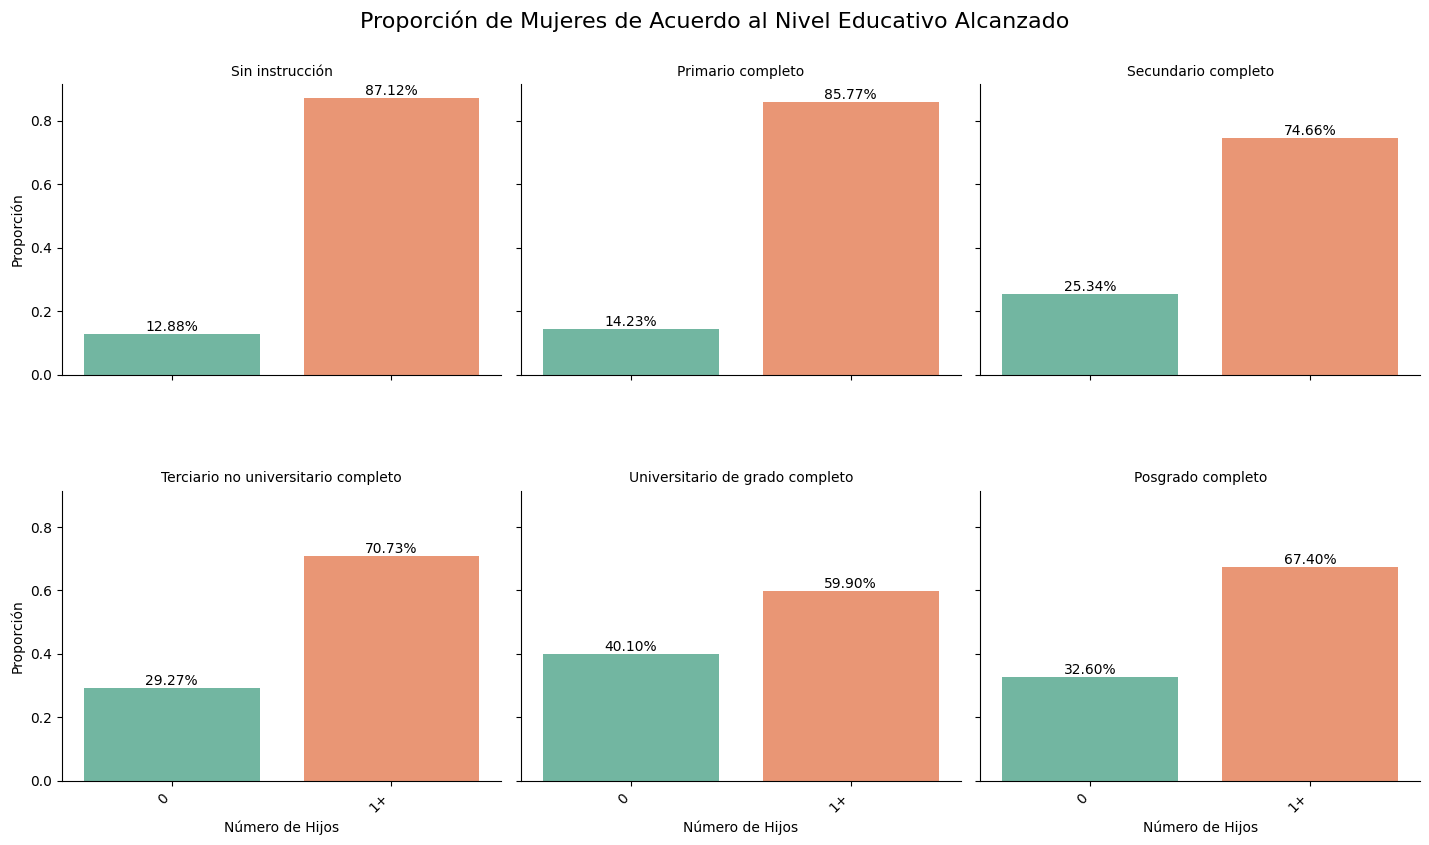

In [196]:


# Create a new column for proportions
df_melted['Proportion'] = (
    df_melted['Value'] / df_melted[aux_c2]
)

# Define a function to plot bars and add text labels
def barplot_with_values(data, x, y, **kwargs):
    ax = plt.gca()  # Get current axis
    sns.barplot(data=data, x=x, y=y, palette="Set2", ax=ax, **kwargs)  # Different colors

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2%}',  # Format as percentage
                    (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom', fontsize=10, color='black')

# Create FacetGrid for multiple plots
g = sns.FacetGrid(df_melted, 
                  col=aux_c1, 
                  col_wrap=3, height=4, aspect=1.2)

# Apply function to plot
g.map_dataframe(barplot_with_values, x='Component', y='Proportion', order=[0, '1+'])

# Set labels and titles

g.set_axis_labels('Número de Hijos', 'Proporción')
g.set_titles("{col_name}")

# Rotate x-axis labels
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Adjust layout to avoid overlap
g.figure.tight_layout()
g.figure.subplots_adjust(hspace=0.4)

# Add a global title
g.figure.suptitle('Proporción de Mujeres de Acuerdo al Nivel Educativo Alcanzado', fontsize=16, y=1.05)

# Show plot
plt.show()


Gracias al gráfico anterior, podemos observar claramente cómo, a medida que el grado educativo aumenta, la proporción de mujeres sin hijos también lo hace. De nuevo, tener en cuenta los pocos ejemplos que tenemos en Posgrado Completo. En el siguiente gráfico de barras, podemos ver de mejor manera esta proporción.

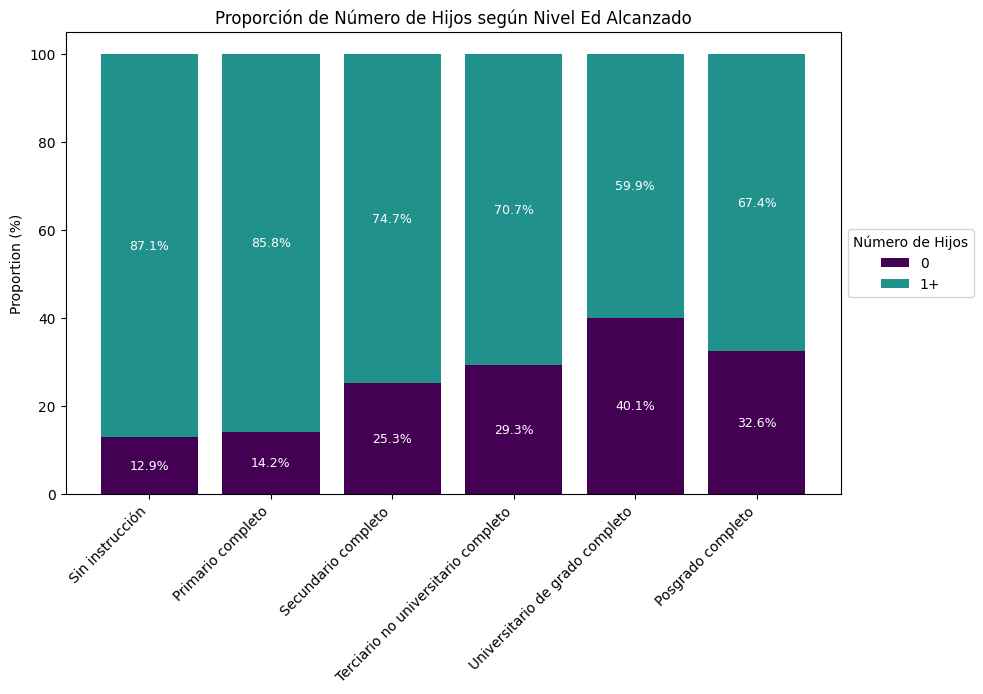

In [197]:

# Pivot the dataframe to get a stacked format
df_pivot = df_melted.pivot_table(
    index=aux_c1, 
    columns='Component', 
    values='Proportion', 
    aggfunc='sum'
)

new_order = [3, 1, 2, 4, 5, 0]  # Replace with the desired row indices
df_pivot = df_pivot.iloc[new_order]



df_percentage = df_pivot.apply(lambda x: x / x.sum(), axis=1) * 100

# Plotting with percentages as labels
fig, ax = plt.subplots(figsize=(10, 6))

bottom = None  # Initialize bottom for stacking

for column in df_percentage.columns:
    values = df_percentage[column]
    bars = ax.bar(df_percentage.index, values, bottom=bottom, label=column, color=plt.cm.viridis(df_percentage.columns.get_loc(column)/len(df_percentage.columns))) # Color by index
    
    # Add percentage labels inside each segment
    for bar in bars:
        height = bar.get_height()
        if height > 5:  # Only label segments with significant height to avoid clutter
            x = bar.get_x() + bar.get_width() / 2  # Center horizontally
            y = bar.get_y() + height / 2  # Center vertically
            ax.text(x, y, f'{height:.1f}%', ha='center', va='center', color='w', fontsize=9)  # White text for visibility

    if bottom is None:
        bottom = values
    else:
        bottom += values

# Get the index labels from the DataFrame
labels = df_percentage.index

# Set the x-axis tick labels explicitly
ax.set_xticks(range(len(labels)))  # Set tick positions (0, 1, 2, ...)
ax.set_xticklabels(labels, rotation=45, ha='right')  # Set and rotate labels

ax.set_ylabel("Proportion (%)")
ax.set_xlabel("")
ax.set_title("Proporción de Número de Hijos según Nivel Ed Alcanzado")
ax.legend(title="Número de Hijos", loc='center left', bbox_to_anchor=(1.0, 0.5))

#plt.tight_layout()
plt.show()


Podemos observar esta relación también en el siguiente gráfico de tortas, notando que en aquel donde se grafica la ausencia de hijos, los grados de educación superiores tienen una proporción mayor.

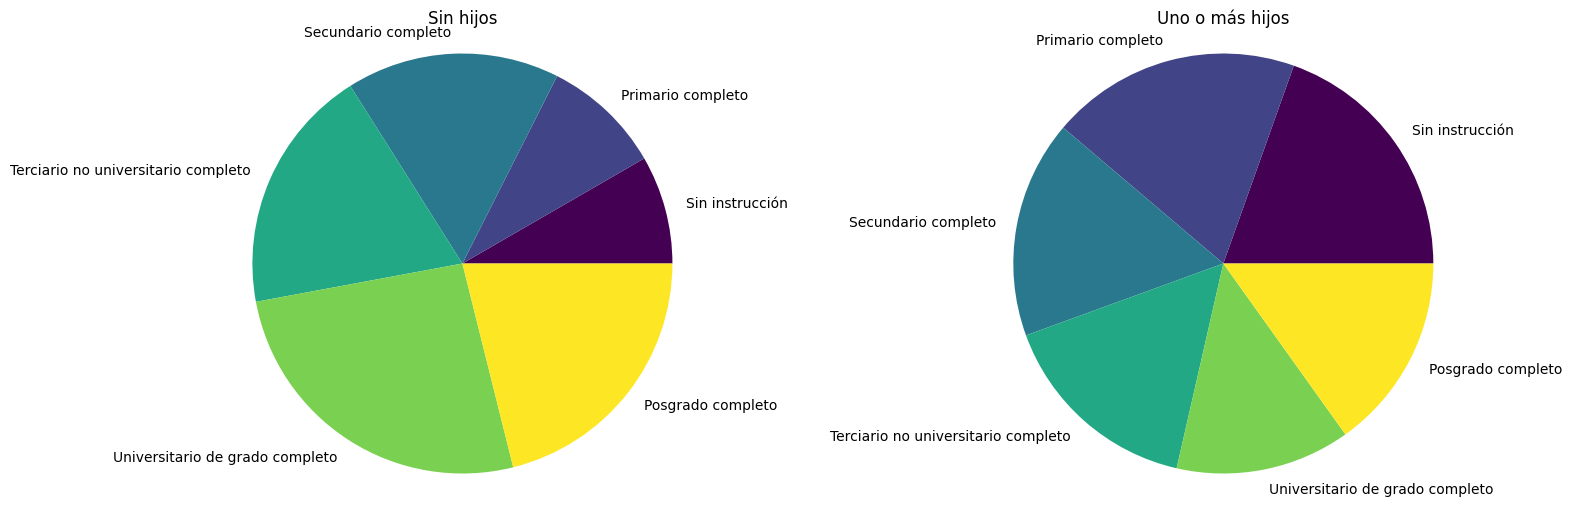

In [198]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))  # Create figure and axes

# Plot the first pie chart on the first subplot (axes[0])
df_pivot.iloc[:, 0].plot(kind='pie', stacked=True, colormap='viridis', ax=axes[0])
axes[0].set_ylabel("")
axes[0].set_xlabel("")
axes[0].set_title('Sin hijos') # Set title based on column name
axes[0].axis('equal')  # Equal aspect ratio for pie charts

# Plot the second pie chart on the second subplot (axes[1])
df_pivot.iloc[:, 1].plot(kind='pie', stacked=True, colormap='viridis', ax=axes[1])
axes[1].set_ylabel("")
axes[1].set_xlabel("")
axes[1].set_title('Uno o más hijos') # Set title based on column name
axes[1].axis('equal')  # Equal aspect ratio for pie charts

# Create a single legend for both subplots (using the first axes as a handle)
#handles, labels = axes[0].get_legend_handles_labels() # Extract handles and labels from first axes
#fig.legend( handles, labels, loc='center left', bbox_to_anchor=(1.0, 0.5), title='Nivel Educativo Alcanzado' ,)
#plt.title('Proporción de Número de Hijos respecto de cada Nivel Educativo Alcanzado')
#plt.tight_layout() # Important: Adjust layout to prevent overlapping
plt.show()

Para culminar el análisis de la proporción, veamos el siguiente Heatmap, donde podemos observar nuevamente como la brecha se va reduciendo a medida que avanza el grado educativo alcanzado, con el caveat mencionado del último eslabón.

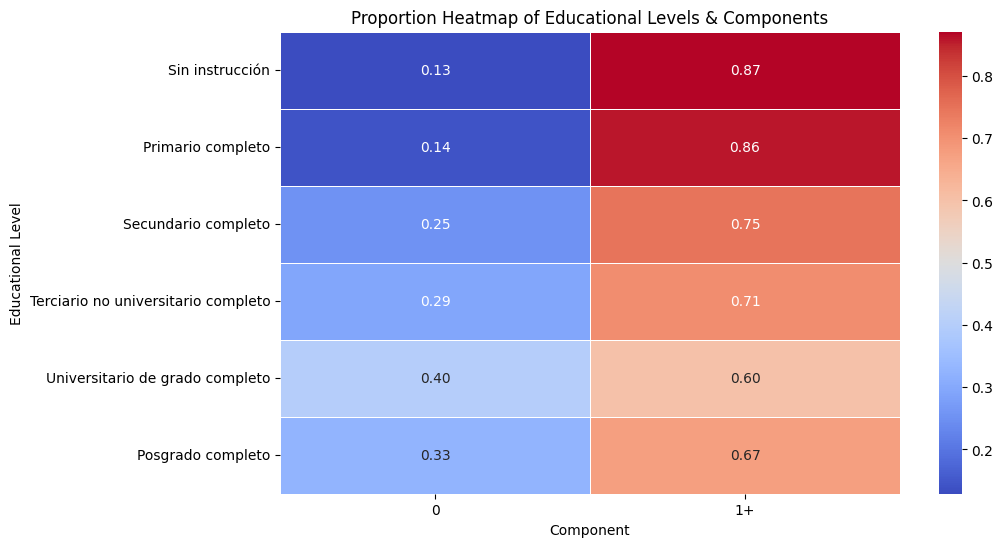

In [199]:
df_pivot = df_pivot.apply(pd.to_numeric, errors='coerce')  # Convert all columns to numeric, setting non-convertible values to NaN

plt.figure(figsize=(10,6))
sns.heatmap(df_pivot, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")

plt.title("Proportion Heatmap of Educational Levels & Components")
plt.xlabel("Component")
plt.ylabel("Educational Level")
plt.show()

### Análisis por cantidad de hijos.

Ahora, vamos a analizar no sólo si una mujer tiene hijos o no, sino el número de ellos. Comencemos viendo la cantidad de mujeres con x cantidad de hijos según el Nivel Ed.

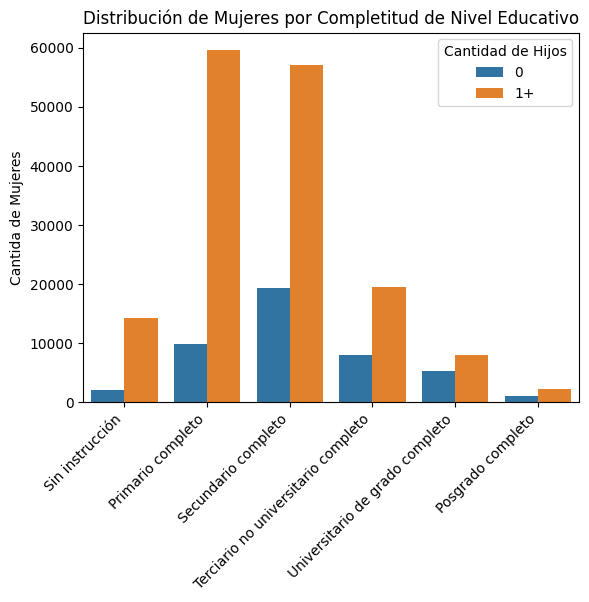

In [200]:
# Melt the DataFrame to long format
df_melted_2 = pd.melt(df_no_tot, id_vars=[aux_c1, 
                                                              aux_c2], 
                    value_vars=[0, 1.0,2.0,3.0,4.0,'5 y más'], 
                    var_name='Component', value_name='Value')

# Create the barplot
sns.barplot(data=df_melted, 
            x=aux_c1, 
            y='Value', 
            hue='Component')
plt.legend(title='Cantidad de Hijos')
plt.title('Distribución de Mujeres por Completitud de Nivel Educativo')
plt.xlabel('')
plt.ylabel('Cantida de Mujeres')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

Como en el caso previo, podemos observar una tendencia similar. Notemos que, en este conjunto de datos, en las mujeres pertenecientes al grupo "Sin instrucción", predomina el tener 5 y hijos y más. Además, en el segundo grupo y tercero, predominan 2 y 3 hijos, respectivamente. Finalmente, del 4to grupo en adelante, la ausencia de hijos es la protagonista. Veamos ahora más de cerca los gráficos para cada grupo y las proporciones.

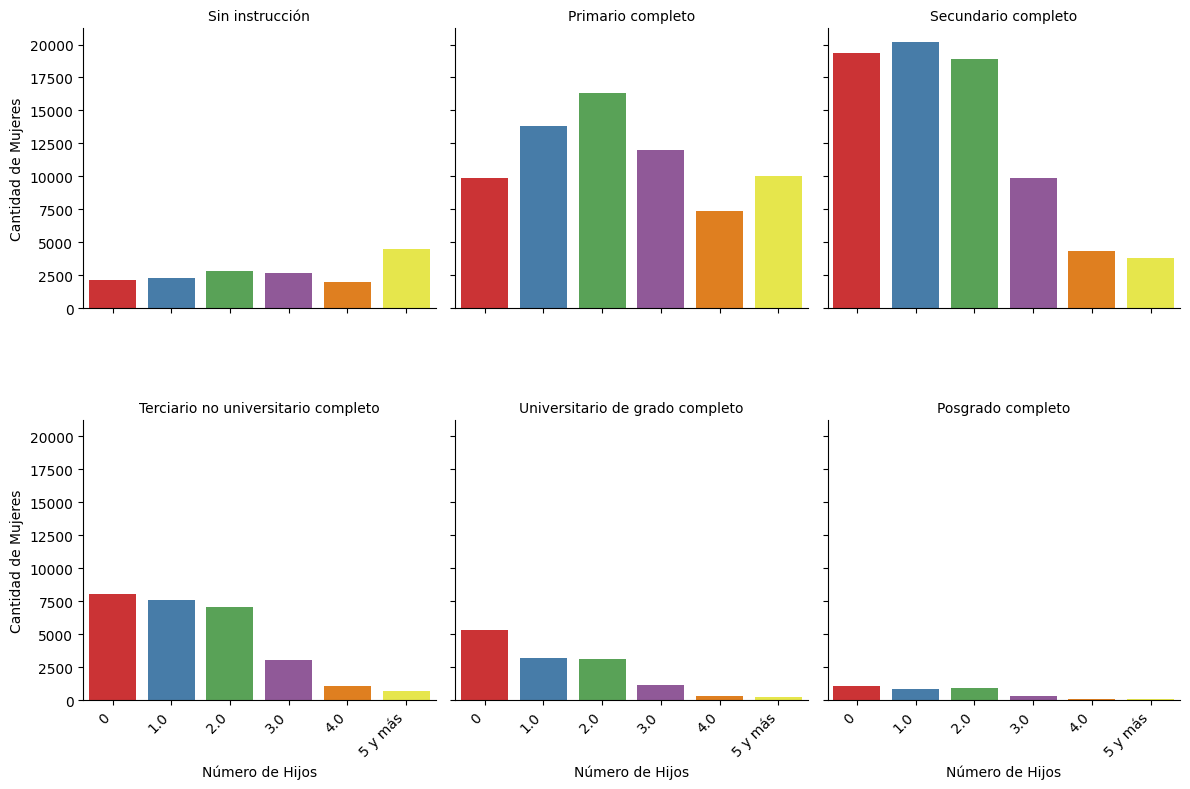

In [201]:
# Create the FacetGrid
g = sns.FacetGrid(df_melted_2, col=aux_c1, 
                  col_wrap=3,  # Number of plots per row, adjust as needed
                  height=4)    # Height of each plot

# Map the barplot to each category
g.map(sns.barplot, 'Component', 'Value', order=[0, 1.0,2.0,3.0,4.0,'5 y más'], palette='Set1')

# Add axis labels and titles
g.set_axis_labels('Número de Hijos', 'Cantidad de Mujeres')
g.set_titles("{col_name}")  # This will set the category names as titles for each plot

# Rotate the x-axis labels for better visibility
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Adjust the layout to avoid overlap
g.figure.tight_layout()
g.figure.subplots_adjust(hspace=0.4)  # Increase vertical spacing between rows

# Show the plot
plt.show()

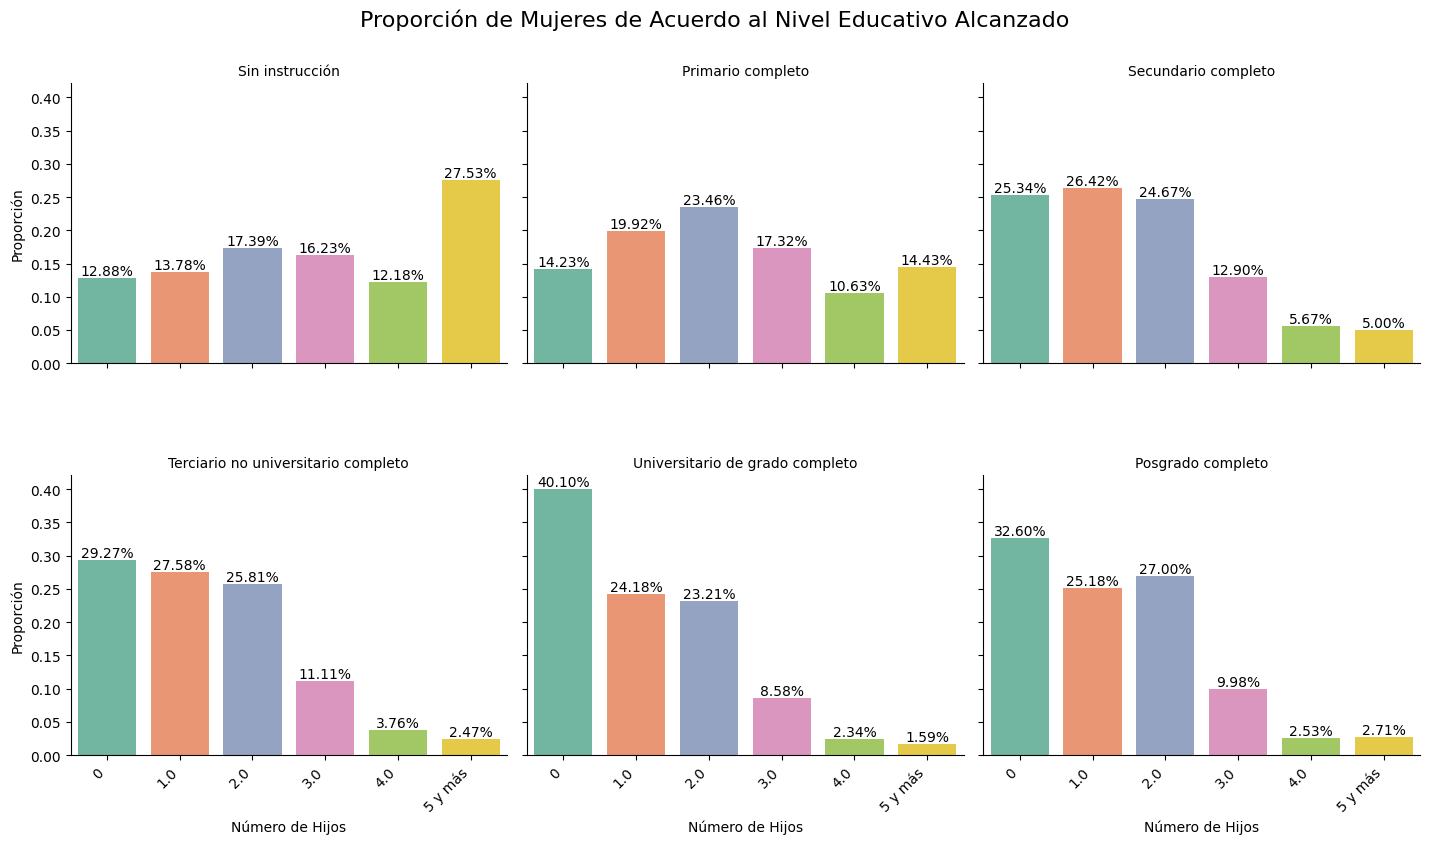

In [202]:


# Create a new column for proportions
df_melted_2['Proportion'] = (
    df_melted_2['Value'] / df_melted_2[aux_c2]
)

# Define a function to plot bars and add text labels
def barplot_with_values(data, x, y, **kwargs):
    ax = plt.gca()  # Get current axis
    sns.barplot(data=data, x=x, y=y, palette="Set2", ax=ax, **kwargs)  # Different colors

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2%}',  # Format as percentage
                    (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom', fontsize=10, color='black')

# Create FacetGrid for multiple plots
g = sns.FacetGrid(df_melted_2, 
                  col=aux_c1, 
                  col_wrap=3, height=4, aspect=1.2)

# Apply function to plot
g.map_dataframe(barplot_with_values, x='Component', y='Proportion', order=[0, 1.0,2.0,3.0,4.0,'5 y más'])

# Set labels and titles

g.set_axis_labels('Número de Hijos', 'Proporción')
g.set_titles("{col_name}")

# Rotate x-axis labels
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Adjust layout to avoid overlap
g.figure.tight_layout()
g.figure.subplots_adjust(hspace=0.4)

# Add a global title
g.figure.suptitle('Proporción de Mujeres de Acuerdo al Nivel Educativo Alcanzado', fontsize=16, y=1.05)

# Show plot
plt.show()


Especialmente en este último gráfico, podemos observar cómo, de manera aproximada, la distribución pasa de ser asimétrica a izquierda a asimétrica a derecha.

En los siguientes gráficos, podemos ver con más detalle cómo el número de hijos disminuye a medida que el Nivel Ed aumenta.

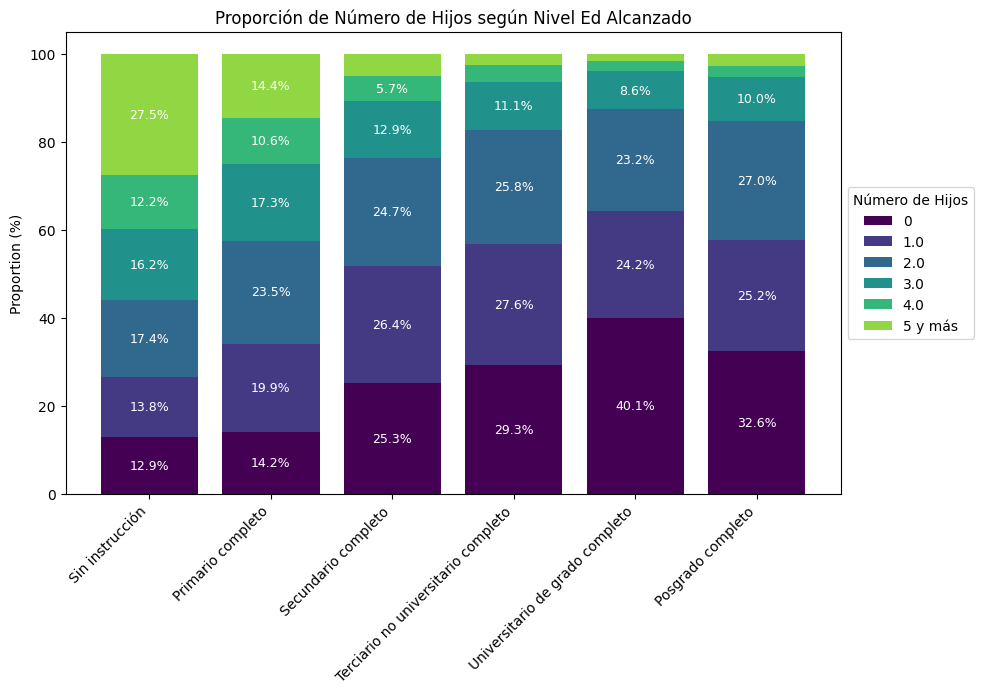

In [203]:

# Pivot the dataframe to get a stacked format
df_pivot_2 = df_melted_2.pivot_table(
    index=aux_c1, 
    columns='Component', 
    values='Proportion', 
    aggfunc='sum'
)

new_order = [3, 1, 2, 4, 5, 0]  # Replace with the desired row indices
df_pivot_2 = df_pivot_2.iloc[new_order]



df_percentage_2 = df_pivot_2.apply(lambda x: x / x.sum(), axis=1) * 100

# Plotting with percentages as labels
fig, ax = plt.subplots(figsize=(10, 6))

bottom = None  # Initialize bottom for stacking

for column in df_percentage_2.columns:
    values = df_percentage_2[column]
    bars = ax.bar(df_percentage_2.index, values, bottom=bottom, label=column, color=plt.cm.viridis(df_percentage_2.columns.get_loc(column)/len(df_percentage_2.columns))) # Color by index
    
    # Add percentage labels inside each segment
    for bar in bars:
        height = bar.get_height()
        if height > 5:  # Only label segments with significant height to avoid clutter
            x = bar.get_x() + bar.get_width() / 2  # Center horizontally
            y = bar.get_y() + height / 2  # Center vertically
            ax.text(x, y, f'{height:.1f}%', ha='center', va='center', color='w', fontsize=9)  # White text for visibility

    if bottom is None:
        bottom = values
    else:
        bottom += values

# Get the index labels from the DataFrame
labels = df_percentage_2.index

# Set the x-axis tick labels explicitly
ax.set_xticks(range(len(labels)))  # Set tick positions (0, 1, 2, ...)
ax.set_xticklabels(labels, rotation=45, ha='right')  # Set and rotate labels

ax.set_ylabel("Proportion (%)")
ax.set_xlabel("")
ax.set_title("Proporción de Número de Hijos según Nivel Ed Alcanzado")
ax.legend(title="Número de Hijos", loc='center left', bbox_to_anchor=(1.0, 0.5))

#plt.tight_layout()
plt.show()


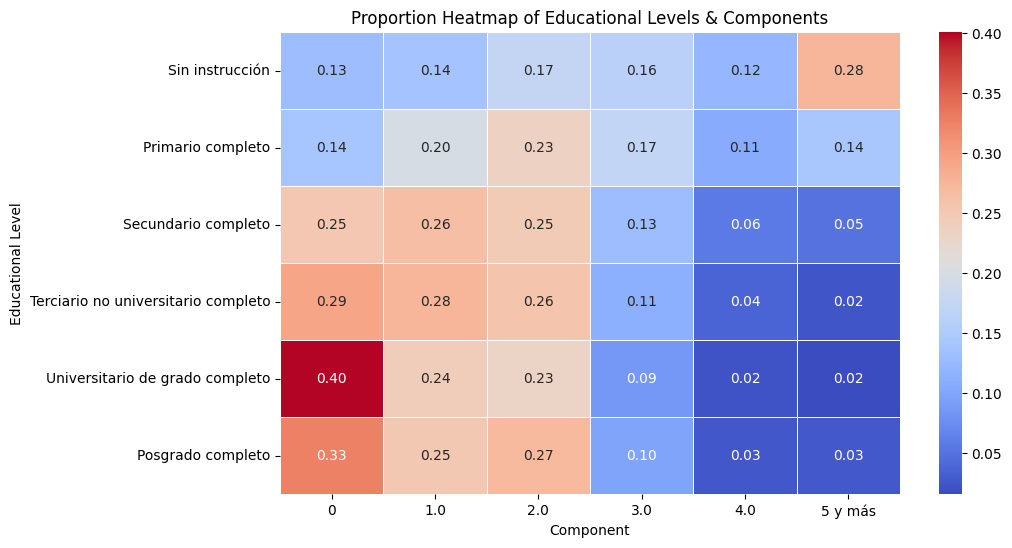

In [204]:
df_pivot_2 = df_pivot_2.apply(pd.to_numeric, errors='coerce')  # Convert all columns to numeric, setting non-convertible values to NaN

plt.figure(figsize=(10,6))
sns.heatmap(df_pivot_2, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")

plt.title("Proportion Heatmap of Educational Levels & Components")
plt.xlabel("Component")
plt.ylabel("Educational Level")
plt.show()

Finalmente, en el siguiente gráfico consideramos a cada torta como el número de hijos, en vez de el nivel educativo (como en el caso del gráfico de barras). Podemos ver, por ejemplo, como a medida que aumenta el número de hijos, la proporción del grupo sin instrucción, aumenta.

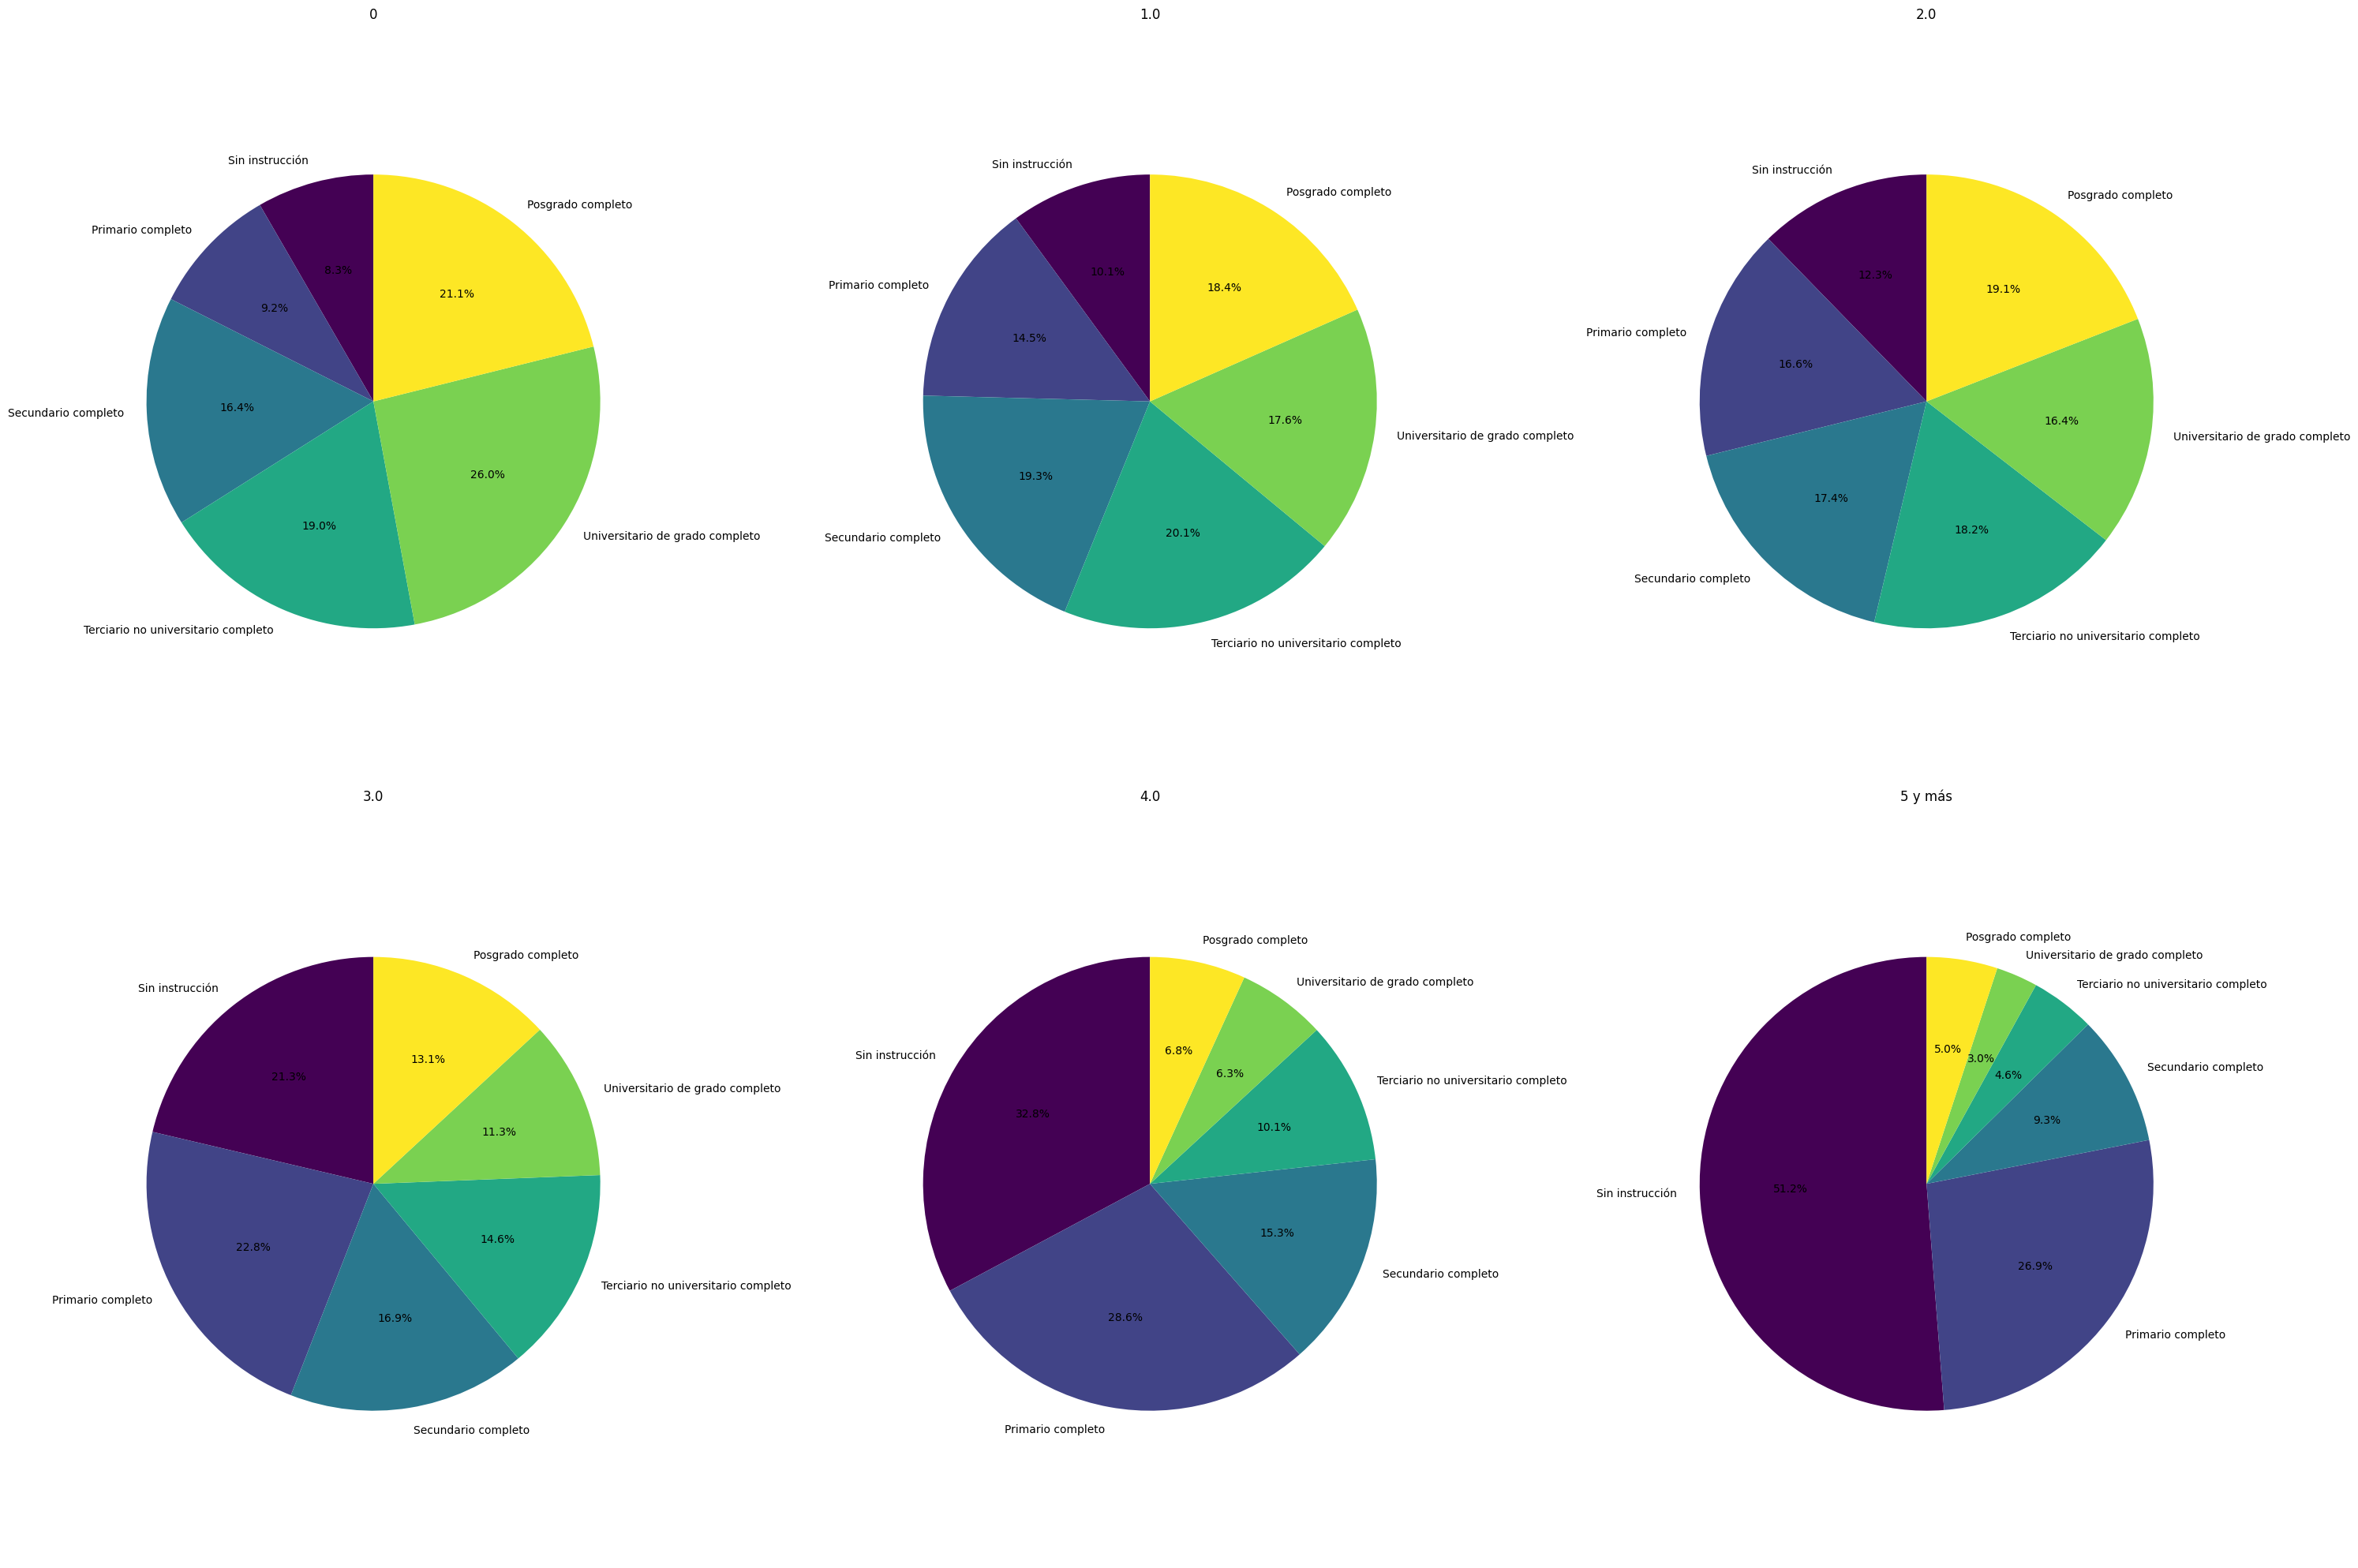

In [205]:

# Pivot the dataframe to get a stacked format

# Plot
# ... (Your code to create df_pivot) ...

n_rows = 2  # Number of rows in the subplot grid
n_cols = 3  # Number of columns in the subplot grid
n_total_plots = n_rows * n_cols

# Check if df_pivot has enough columns
if len(df_pivot_2.columns) < n_total_plots:
    raise ValueError("df_pivot does not have enough columns for the specified number of subplots.")

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(30, 20))

# Flatten the axes array for iteration
if isinstance(axes, np.ndarray):
    axes = axes.flatten()
else:
    axes = np.array([axes])

wedges_all = []  # List to store all wedge objects for the legend

for i, ax in enumerate(axes[:len(df_pivot_2.columns)]):  # Iterate up to the number of columns in df_pivot
    if i < len(df_pivot_2.columns):  # Check if we have data for this subplot
        plot_return = df_pivot_2.iloc[:, i].plot(kind='pie', stacked=True, colormap='viridis', ax=ax, autopct='%1.1f%%', startangle=90)
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_title(df_pivot_2.columns[i])
        ax.axis('equal')
        wedges_all.extend(plot_return.patches)
    else:
        fig.delaxes(ax)  # Delete unused subplots

# Create the legend (using wedges from the first subplot is fine)
labels = df_pivot_2.index
#fig.legend(wedges_all[:len(df_pivot.index)], labels, loc='center left', bbox_to_anchor=(1.0, 0.5), title="Educational Level")

plt.tight_layout()
plt.show()

## Conclusiones

A partir de los porcentajes calculados, podríamos decir que, si elegimos una mujer de manera aleatoria en nuestro conjunto de datos...  

-Si tiene un título universitario de grado, existe un 40% de posibilidades de que dicha mujer no tenga hijos.  

-Si no posee instrucción, hay casi un 30% de chances de que dicha mujer tenga 5 y más hijos.  

-Si el máximo título alcanzado es el nivel secundario, hay un 75% de posibilidades de que dicha mujer tenga al menos 1 hijo. 

Una pregunta que podríamos hacernos es, ¿el hecho de que una mujer alcance cierto nivel educativo implica que tenga cierta cantidad de hijos? ¿o el hecho de que tenga cierta cantidad de hijos implica que alcance cierto nivel nivel educativo?   
La respuesta es, we don't know, con los datos que tenemos, no podemos afirmar si, por ejemplo, una mujer (teniendo la oportunidad) decidió avanzar hasta el máximo nivel educativo, lo cual, para ella, requirió no tener hijos por diferentes motivos, o si, por el contrario, el hecho de que una mujer tuviera hijos, fue un impedimento para continuar su educación.

Finalmente, luego del análisis realizado, podemos concluir que, al menos en este conjunto de datos, un mayor nivel de educación alcanzado por una mujer, implica una menor tasa de fecundidad.

<h5 style="text-align: right;"> Autor: Fernán Z L </h5>


<h6 style="text-align: right;"> Fuente del Conjunto de Datos: INDEC, www.indec.gob.ar </h6>
